In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
# import netcdf4
import geopandas as gpd
import rasterio
import netCDF4 as nc
import numpy as np
from shapely.geometry import Point
from shapely.vectorized import contains

In [2]:
# Open the NetCDF file
nc_file = '/global/scratch/users/arvalcarcel/CSMUB/DATA/GLDASp5_soiltexture_025d.nc4'
ds = xr.open_dataset(nc_file)

# Display the dataset summary
ds

<xarray.Dataset>
Dimensions:        (lon: 1440, lat: 600, time: 1, bnds: 2)
Coordinates:
  * lon            (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * lat            (lat) float32 -59.88 -59.62 -59.38 ... 89.38 89.62 89.88
  * time           (time) datetime64[ns] 2000-01-01
Dimensions without coordinates: bnds
Data variables:
    time_bnds      (time, bnds) datetime64[ns] ...
    GLDAS_soiltex  (time, lat, lon) float32 ...
Attributes: (12/13)
    missing_value:          -9999.0
    time_definition:        constant
    title:                  GLDAS p5 data
    institution:            NASA GSFC
    history:                created on date: Fri Nov  6 15:43:37 2020
    references:             Rodell_etal_BAMS_2004,Kumar_etal_EMS_2006,Peters-...
    ...                     ...
    website:                https://ldas.gsfc.nasa.gov/gldas/, https://lis.gs...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  -59.875
    SOUTH_WEST_CORNER_LON:  -179.875
    DX:                     0.25
    DY:                     0.25

In [3]:
variable_name = "GLDAS_soiltex"  # Change to a relevant variable from ds.variables
data_var = ds[variable_name]

# Display variable attributes
print(data_var)

<xarray.DataArray 'GLDAS_soiltex' (time: 1, lat: 600, lon: 1440)>
[864000 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat      (lat) float32 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * time     (time) datetime64[ns] 2000-01-01
Attributes:
    units:          none
    standard_name:  soil texture type
    long_name:      GLDAS soil texture type in NOAH3.6
    cell_methods:   time: mean
    vmin:           0.9999999
    vmax:           16.000002


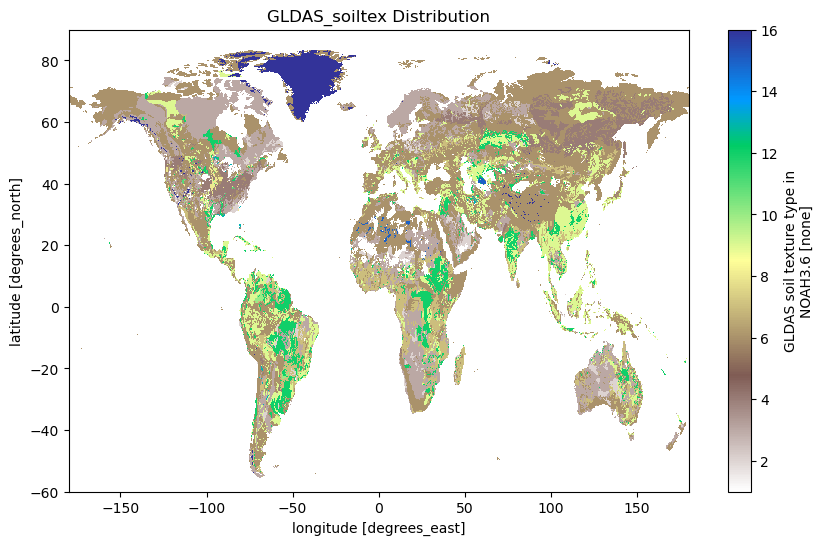

In [4]:
# Select the first time step if time dimension exists
if "time" in data_var.dims:
    data_var = data_var.isel(time=0)

# Plot the data
plt.figure(figsize=(10, 6))
data_var.plot(cmap="terrain_r")
plt.title(f"{variable_name} Distribution")
plt.show()

In [5]:
#### DEFINE INPUTS FOR FUNCTION
masterlist = '/global/scratch/users/arvalcarcel/CSMUB/RESULTS/ALL_STATIONS_FINAL_REVISED.csv'

full_df = pd.read_csv(masterlist)
station_num = full_df['grdc_no']

# for i in range(0):
i = 107
data = full_df.iloc[i]
number = data['grdc_no']
region = data['wmo_reg']
river = data['river']
name = data['station']
lat = data['lat']
lon = data['long']
area = data['area']
altitude = data['altitude']
shp_log = data['shapefile_code']
print(shp_log)
# output_tif = f'/global/scratch/users/arvalcarcel/CSMUB/DATA/DEM/STATIONS/{number}_dem.tif'

2


In [6]:
# Read the shapefiles
shapefile1 = f'/global/home/users/arvalcarcel/ondemand/data/dem/{number}/{number}.shp' # delineated shapefile
shapefile2 = f'/global/scratch/users/arvalcarcel/CSMUB/DATA/SHAPEFILES/{number}/{number}.shp' # GRDC shapefile

if shp_log == 1:
    shapefile = shapefile1

elif shp_log == 2:
    shapefile = shapefile2

In [7]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import netCDF4 as nc
import pandas as pd
import xarray as xr

# Load the NetCDF data
with nc.Dataset(nc_file) as dataset:
    soil = dataset.variables['GLDAS_soiltex'][:]  # Soil data (masked)
    latitude = dataset.variables['lat'][:]  # Latitude values
    longitude = dataset.variables['lon'][:]  # Longitude values
    soil_masked = dataset.variables['GLDAS_soiltex'][:]
    soil_masked = np.ma.masked_equal(soil_masked, -9999)  # Mask invalid values (assuming -9999 is used for missing data)

# Remove the singleton time dimension (if present)
soil = soil_masked.squeeze()  # Removes the first dimension if it's size 1

# Check the shape after squeezing
print(f"Shape after squeezing: {soil.shape}")

# Convert the masked array to a regular numpy array with NaN for masked values
soil = soil.filled(np.nan)

# Check if the entire soil data is NaN
if np.all(np.isnan(soil)):
    print("Warning: All soil data is NaN after masking. Please check the data source or bounds.")
else:
    print(f"Data contains valid values. Shape: {soil.shape}")

# Create an xarray Dataset for easy interpolation
# The shape should now be (600, 1440)
data_set = xr.Dataset({"soil": (["lat", "lon"], soil)},
                 coords={"lat": latitude, "lon": longitude})

# Load the shapefile and reproject it to EPSG:4326 if needed
shp = gpd.read_file(shapefile).to_crs('EPSG:4326')
minlon, minlat, maxlon, maxlat = shp.geometry.total_bounds

# Crop the data to the bounds of the shapefile
lat_mask = (latitude >= minlat) & (latitude <= maxlat)
lon_mask = (longitude >= minlon) & (longitude <= maxlon)
cropped_soil = soil[lat_mask, :][:, lon_mask]

# Check if the cropped data is empty or full of NaNs
if np.all(np.isnan(cropped_soil)):
    print("Warning: Cropped soil data is empty or full of NaNs. Please check your shapefile bounds or data.")
else:
    print(f"Cropped data has valid values. Shape: {cropped_soil.shape}")

# Create new latitude and longitude arrays for the desired resolution
dx_new = 0.1  # Desired resolution
newlon = np.arange(minlon, maxlon, dx_new)
newlat = np.arange(minlat, maxlat, dx_new)

# Interpolate the data to the new grid
data_set_interp = data_set.interp(lat=newlat, lon=newlon)

# # Check the interpolated result
# print(data_set_interp)

Shape after squeezing: (600, 1440)
Data contains valid values. Shape: (600, 1440)


int64


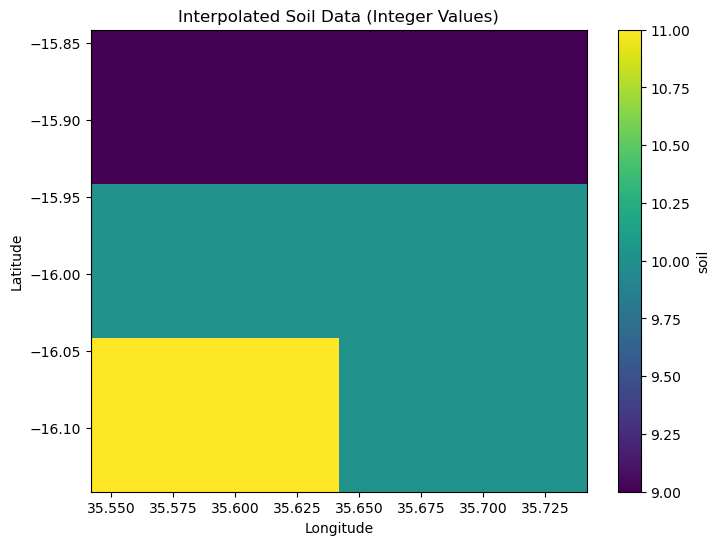

In [8]:
# Ensure NaN values are replaced with a placeholder integer (e.g., -9999)
# This is necessary as NaN values can't be represented by integers directly.
data_set_interp['soil'] = data_set_interp['soil'].fillna(-9999)

# Convert the values to integers
data_set_interp['soil'] = data_set_interp['soil'].astype(int)

# Check if the values are now integers
print(data_set_interp['soil'].dtype)

# Optionally, visualize the interpolated soil data after converting to integers
plt.figure(figsize=(8, 6))
data_set_interp['soil'].plot(cmap='viridis')
plt.title('Interpolated Soil Data (Integer Values)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [9]:
# Extract the 'soil' data as a NumPy array from the xarray Dataset
soil = data_set_interp['soil'].values

# Flatten the array to make it 1D, as value counts work on 1D data
soil_flat = soil.flatten()

# Count occurrences of each integer between 1 and 16 (inclusive)
soil_counts = {i: np.sum(soil_flat == i) for i in range(1, 17)}

# Compute the total number of points in the dataset
total_points = soil_flat.size  # This is the total number of elements in the flattened array

# Calculate the percentage of each value
percentages = {key: (count / total_points) * 100 for key, count in soil_counts.items()}

# Display the results as a pandas Series for better readability
percentages_df = pd.Series(percentages).sort_index()

# Print the percentage distribution for each soil class (1-16)
print(percentages_df)


1      0.000000
2      0.000000
3      0.000000
4      0.000000
5      0.000000
6      0.000000
7      0.000000
8      0.000000
9     33.333333
10    50.000000
11    16.666667
12     0.000000
13     0.000000
14     0.000000
15     0.000000
16     0.000000
dtype: float64


In [15]:
most_common_class = percentages_df.idxmax()
print(most_common_class)

10


In [ ]:
# soil = data_set_interp['soil']
# percentages = []

# # Count occurrences of each soil class (ensuring values are between 1 and 16)
# soil_counts = soil.value_counts().sort_index()

# # Filter to include only values in range 1-16
# soil_counts = soil_counts.reindex(range(1, 17), fill_value=0)

# # Compute percentages
# total_points = len(gdf)
# percentages = (soil_counts / total_points) * 100

# # Display results
# print(percentages)

In [ ]:
    # Convert percentages to a DataFrame row
    new_row = pd.DataFrame([percentages])
    new_row["number"] = number  # Add 'number' as a separate column
    new_row.set_index("number", inplace=True)  # Set 'number' as the index

    # Append to df_landcover
    df_landcover = pd.concat([df_landcover, new_row])

results_csv = f"/global/scratch/users/arvalcarcel/CSMUB/RESULTS/CSV/ALL_STATIONS_LANDCOVER.csv"
df_landcover.to_csv(results_csv)
print(pd.read_csv(results_csv))